# **KGFarm**
**A Feature Discovery system for Machine learning workflows**
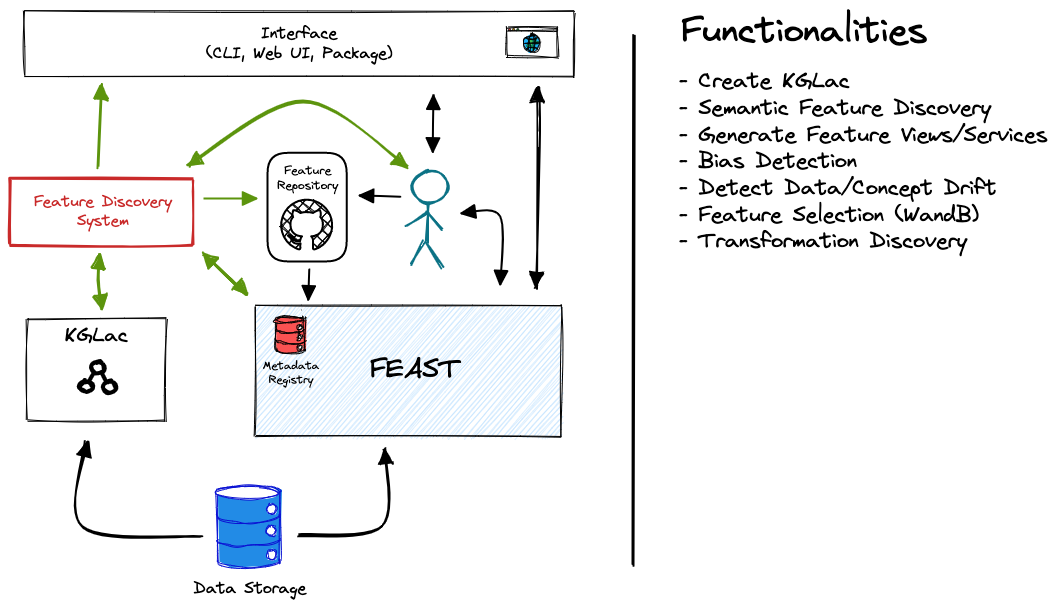






In [ ]:
from operations.api import KGFarm
kgfarm = KGFarm()


**Automate generation of [Entities](https://docs.feast.dev/getting-started/concepts/entity) & [Feature Views](https://docs.feast.dev/getting-started/concepts/feature-view)**








In [ ]:
kgfarm.get_entities()

In [ ]:
feature_view_df = kgfarm.get_feature_views()
feature_view_df

**Drop Feature Views**
  *   Pass the feature views to be deleted as a <code>pandas.Series</code> object.


In [ ]:
kgfarm.drop_feature_view(drop=[feature_view_df.iloc[14]])

**Update Entity for a particular Feature_view**
  *   Use KGFarm's <code>get_optional_physcial_representations()</code> to discover other promising physical representations of an entity.
  *   To update existing entities of your choice. Use KGFarm's <code>update_entity()</code> API. 
  *   Pass your choice(s) from <code>get_optional_physcial_representations()</code> to <code>update_entity(entity_to_update_info: list)</code>.

In [ ]:
optional_physical_representations_df = kgfarm.get_optional_physical_representations()
optional_physical_representations_df

In [ ]:
kgfarm.update_entity([optional_physical_representations_df.iloc[0]])

## **A practical usecase**

**Entity search**

In [ ]:
import pandas as pd
entity_info = kgfarm.search_entity('customer')
entity_info

   
**Conventional approach for building a machine learning classifier** 


In [ ]:
entity_df = pd.read_csv(entity_info.iloc[0].File_source)
print(entity_info.iloc[0].Physical_table)
entity_df

In [ ]:
entity_df['membership'] = entity_df['membership'].apply(lambda x: 1 if x == 'yes' else 0)
entity_df.reset_index(drop=True, inplace=True)
entity_df

**Manual feature selection**

In [ ]:
X = entity_df[['age', # here age, balance, day, duration, ... are the necessary features for model building
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'n_accounts',
 'deposit']]

y = entity_df['membership']

**Training Machine learning classifiers**<br><br>
<i>(Random forest, Gradient boosting and naive bayes in this case)</i>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# instanciate the models
random_forest_classifier = RandomForestClassifier()
gradient_boosting_classifier = GradientBoostingClassifier()
naive_bayes_classifier = GaussianNB()

# fit the models on data
random_forest_classifier.fit(X_train, y_train)
gradient_boosting_classifier.fit(X_train, y_train)
naive_bayes_classifier.fit(X_train, y_train)

# evaluate model performance
y_pred = random_forest_classifier.predict(X_test)
f1_random_forest_classifier = round(f1_score(y_test, y_pred), 3)
y_pred = gradient_boosting_classifier.predict(X_test)
f1_gradient_boosting_classifier = round(f1_score(y_test, y_pred), 3)
y_pred = naive_bayes_classifier.predict(X_test)
f1_naive_bayes_classifier = round(f1_score(y_test, y_pred), 3)

In [ ]:
from helpers.helper import plot_scores, plot_comparison
conventional_approach = {'Random forest classifier': f1_random_forest_classifier,
                         'Gradient boosting classifier': f1_gradient_boosting_classifier,
                         'Naive bayes classifier': f1_naive_bayes_classifier}
    
plot_scores(conventional_approach)

for classifier, f1 in conventional_approach.items():
    print(f"{'{} (f1-score):'.format(classifier):<42}{f1:>1}")

##  **Automating Feature discovery and transformations using KGFarm** 

**Searching for enrichable tables**<br><br> 
<code>kgfarm.search_enrichment_options()</code> returns set of tables / <code>entity_df</code> and the corresponding Feature view that could be used in order to enrich them with fresh set of features.
  *   <b><code>Joinability_strength</code></b> represents how much a given table / <code>entity_df</code> and a Feature view are joinable. 
  * <b>    You can also pass your <code>entity_df</code> to <code>kgfarm.search_enrichment_options(entity_df: pd.Dataframe)</code> to get the corresponding Feature view that could be used for feature enrichment.</b>

In [ ]:
enrichment_info = kgfarm.search_enrichment_options(entity_df)
enrichment_info

**Enriching data with point in time correct joins**<hr>

KGFarm can join features from a feature view to an entity dataframe in a <b>point-in-time correct way</b> i.e. KGFarm can retrieve values at a specific points in time.
KGFarm scans backward in time from the entity dataframe timestamp up to a maximum of the <code>TTL</code>  (parameter passed by user) 

 *   <code>kgfarm.enrich()</code> takes the following as input:<br>
     1. Feature view metadeta from <code>kgfarm.search_enrichment_options()</code>
     2. <code>entity_df</code> that needs to be enriched and
     3. <code>ttl</code> time to leave parameter (in days)<br>
     and returns an enriched set of features joined in point-in-time correct manner.
  

In [ ]:
entity_df = kgfarm.enrich(enrichment_info.iloc[0], entity_df, ttl=10)
entity_df

**Recommending feature transformations**

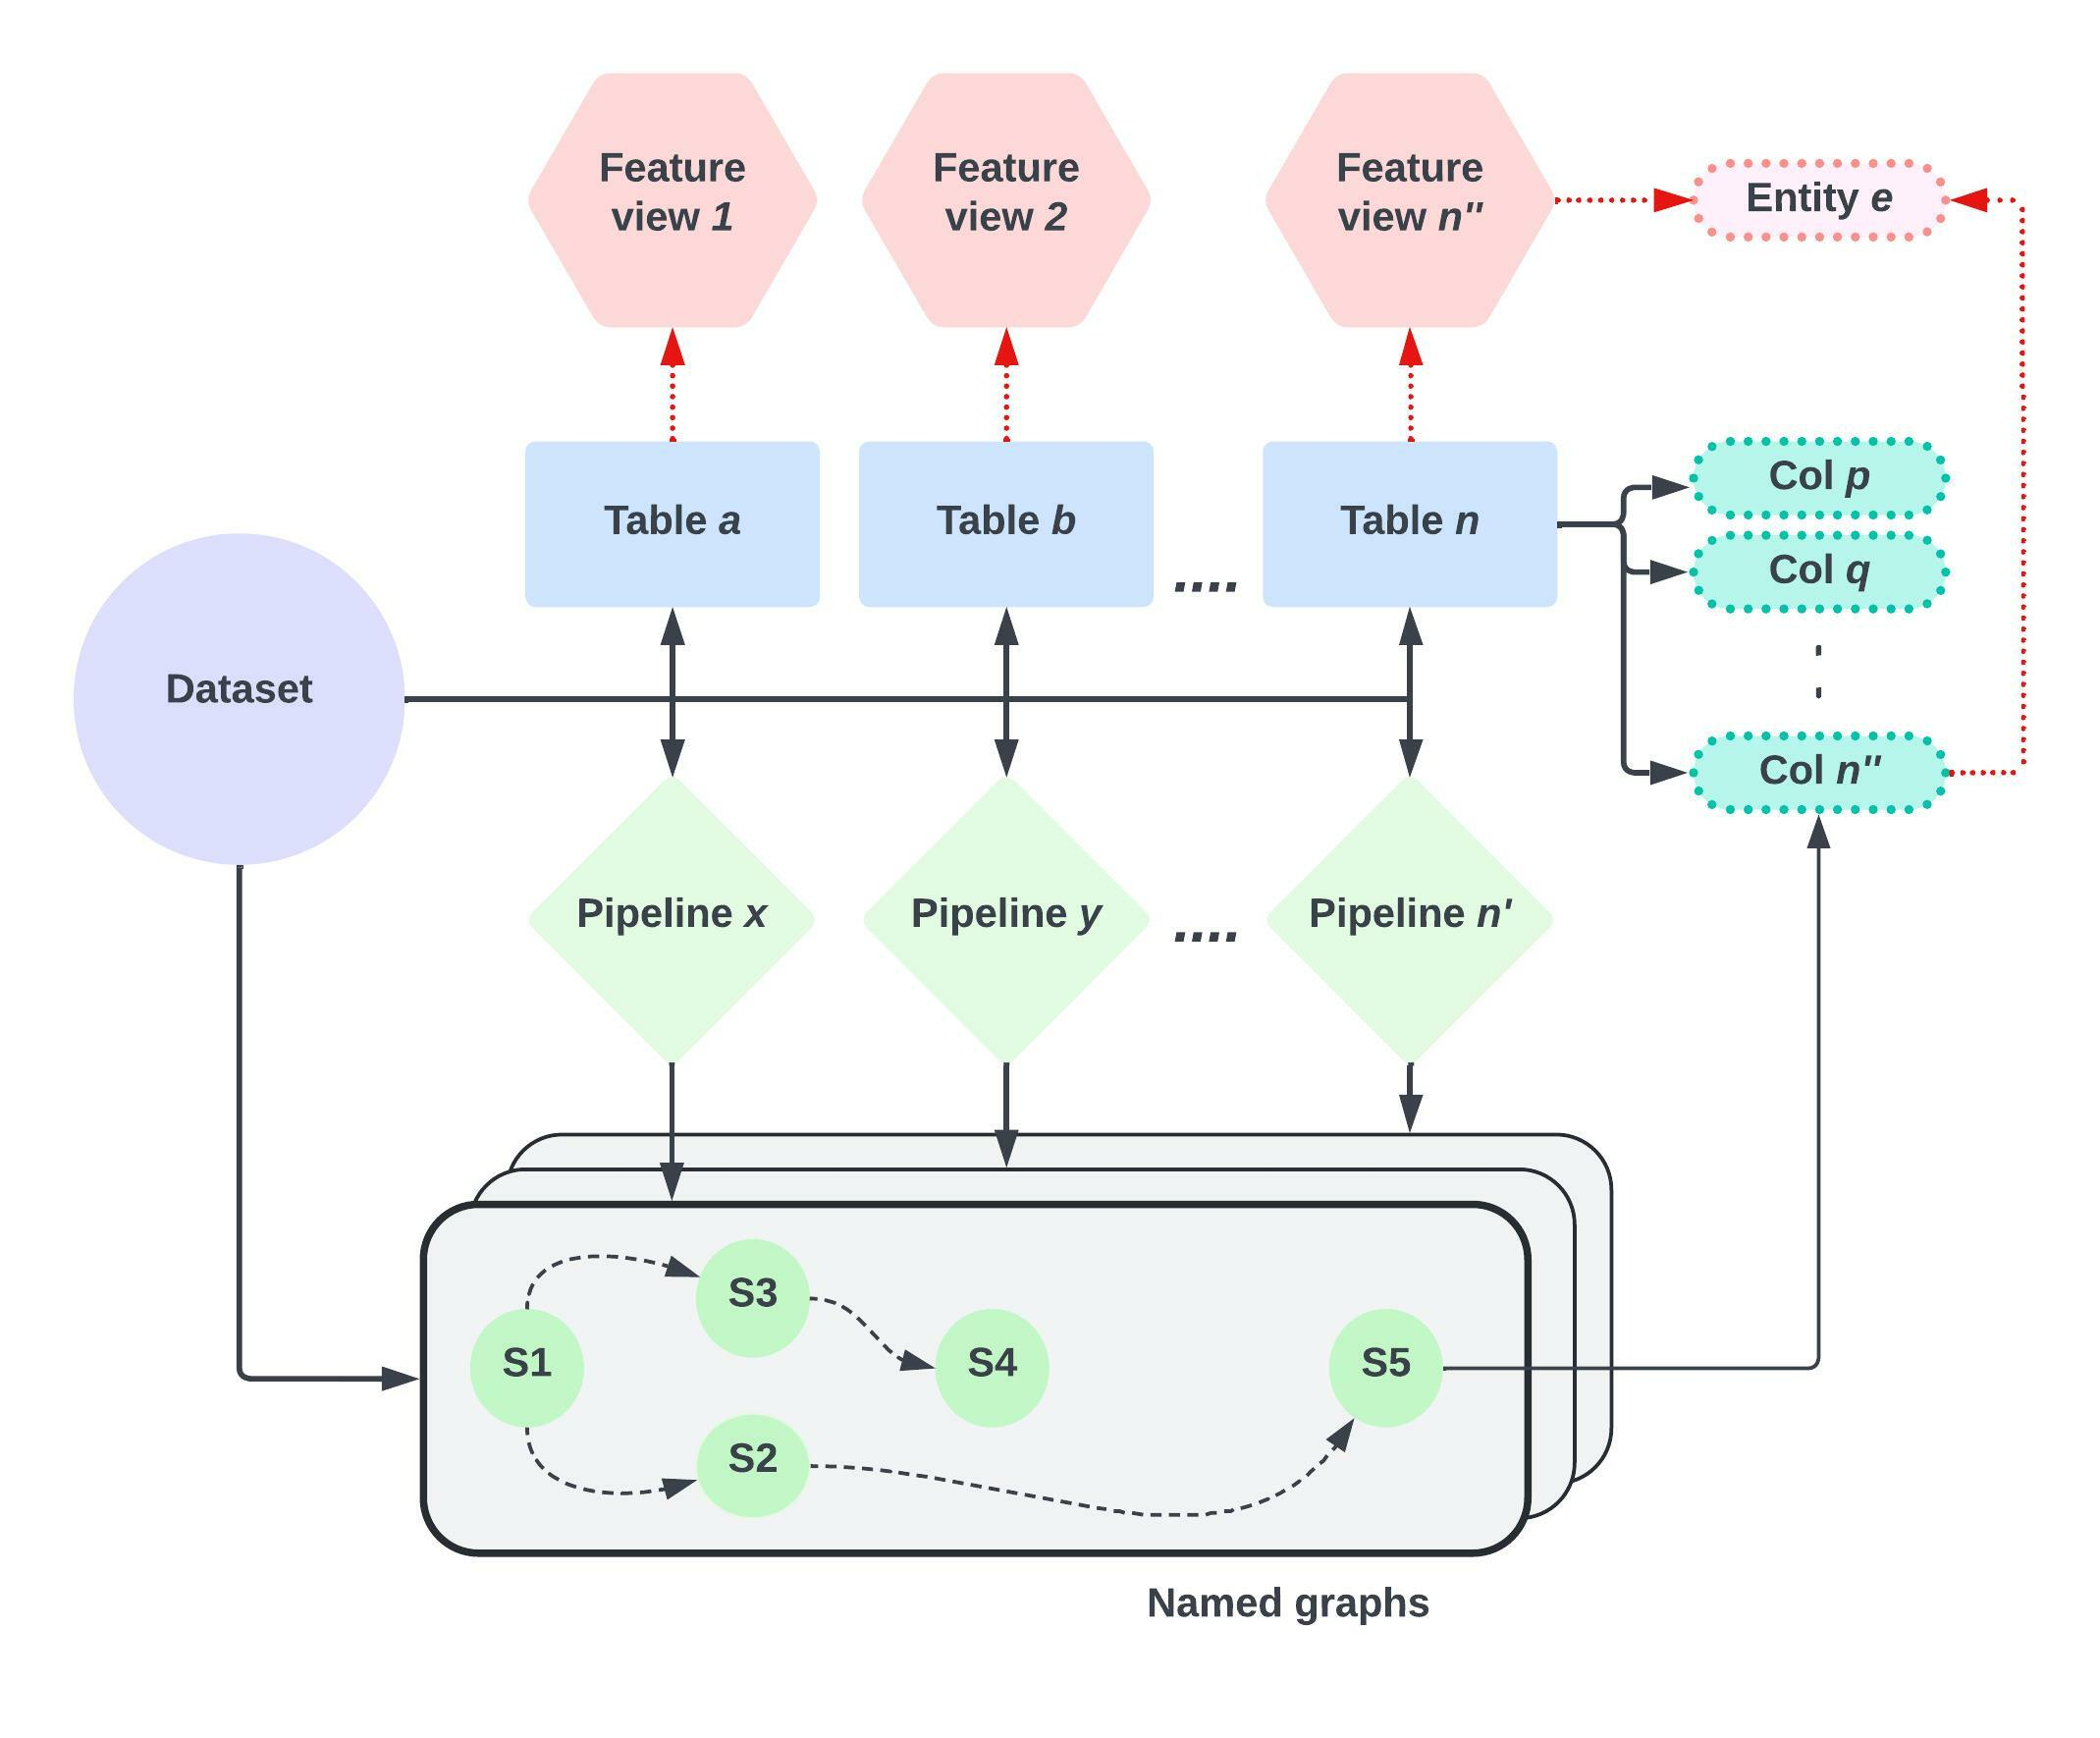


KGFarm exploits the abstracted link between the KGLiDS graph and Farm graph
   * <code> kgfarm.recommend_feature_transformations</code> returns all possible set of feature transformations that exists in the database.
   * <b> You can pass your existing <code>entity_df</code> to <code>kgfarm.recommend_feature_transformations(entity:pd.Dataframe)</code> to look for possible feature transformations for that very entity dataframe.

In [ ]:
transformation_info = kgfarm.recommend_feature_transformations(entity_df)
transformation_info

**Transforming features on the fly**

<code>kgfarm.apply_transformations</code> applies the recommended set of transformations from <code>kgfarm.recommend_feature_transformations</code> to your <code>entity_df</code>

   * <code>kgfarm.apply_transformations</code> expects the following as the input:<br>
     1. Transformation metadata from <code>kgfarm.recommend_feature_transformations</code> and
     2. <code>entity_df</code>


In [ ]:
entity_df = kgfarm.apply_transformation(transformation_info.iloc[0], entity_df)
entity_df

**Feature selection**<br>
KGFarm performs feature selection based on ANOVA test <code>kgfarm.select_features()</code>, takes the following parameters as input:
  1. entity dataframe
  2.  depndent variable / target / label i.e. <i>y</i>
  3.  <code>f_value_threshold</code> (2.0 default)

In [ ]:
X, y = kgfarm.select_features(entity_df, dependent_variable='membership', select_by='pipeline',
                                        plot_correlation=True, plot_anova_test=True, show_f_value=False)
X

**Re-training the classifiers with fresh and enrich set of selected features**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

random_forest_classifier.fit(X_train, y_train)
gradient_boosting_classifier.fit(X_train, y_train)
naive_bayes_classifier.fit(X_train, y_train)

y_pred = random_forest_classifier.predict(X_test)
f1_random_forest_classifier = round(f1_score(y_test, y_pred), 3)
y_pred = gradient_boosting_classifier.predict(X_test)
f1_gradient_boosting_classifier = round(f1_score(y_test, y_pred), 3)
y_pred = naive_bayes_classifier.predict(X_test)
f1_naive_bayes_classifier = round(f1_score(y_test, y_pred), 3)

kgfarm_approach = {'Random forest classifier': f1_random_forest_classifier,
                         'Gradient boosting classifier': f1_gradient_boosting_classifier,
                         'Naive bayes classifier': f1_naive_bayes_classifier}

In [ ]:
plot_comparison(conventional_approach, kgfarm_approach)